In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
#metabolism = load_data('metabolism.23Aug2022.pkl')
#model_id = "metabolism.v4.20Mar2023.pkl"
#model_id = "metabolism.v5.12Apr2023.pkl"
#model_id = "metabolism.v6.26Apr2023.pkl"

model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('../assets/models/' + model_id)

cids = metabolism.coenzymes

In [91]:
# prepare the network 
reaction_df = {"reaction":[],"direction":[],"reaction_def":[],"coenzyme":[]}
for (reaction,direction),dff in metabolism.network.groupby(["rn","direction"]):
    #dff = dff.groupby("cid").sum()
    dff["stoich"] = dff.s.apply(lambda x: str(int(abs(x))))
    dff["stoich"] = dff["stoich"].apply(lambda x: x.replace("1",""))
    dff["reagent"] = dff["stoich"] + dff["cid"] 
    substrates = dff[dff["s"] < 0]
    products = dff[dff["s"] > 0]
    rxn_string = " + ".join(substrates.reagent.tolist()) + " => " +  " + ".join(products.reagent.tolist())
    reaction_df["reaction"].append(reaction)
    reaction_df["direction"].append(direction)
    reaction_df["reaction_def"].append(rxn_string)
    c = substrates.cid.tolist()
    c = ", ".join(cids[cids.ZID.isin(c)]["Coenzyme Name"].tolist())
    reaction_df["coenzyme"].append(c)
    
reaction_df = pd.DataFrame(reaction_df)

In [132]:
def rxn_classify(rxn):
    if ("R" == rxn[0]) & ("_v" in rxn):
        return "KEGG (Modified)"
    elif ("R" == rxn[0]) & ("_v" not in rxn):
        return "KEGG"
    else:
        return "Manual"

reaction_df["ReactionType"] = reaction_df["reaction"].apply(rxn_classify)

In [137]:
reaction_df = reaction_df[["reaction","direction","ReactionType","coenzyme","reaction_def"]]

,reaction,direction,ReactionType,coenzyme,reaction_def
0,C00404_syn,forward,Manual,,C00536 => C00404
1,C00862_syn,forward,Manual,,C21070 => C00862
2,C01070_syn,forward,Manual,"Fe, Heme",Z00025 + Z00015 => C01070
3,C01071_syn,forward,Manual,"Fe, Heme",Z00025 + Z00015 => C01071
4,C04253_syn,forward,Manual,Flavin,C00017 + Z00017 => C04253
...,...,...,...,...,...
18935,protein_syn,forward,Manual,,C00037 + C00041 + C00183 + C00123 + C00407 + C...
18936,sulfurcarrier_syn,forward,Manual,,C00017 + C00017 => C15810 + C15810
18937,thiolprot_syn,forward,Manual,,C00017 => C15814
18938,thioredoxin1_syn,forward,Manual,,C00017 => C00343


In [138]:
reaction_df.set_index("reaction").to_csv("SI_tables/S1.csv")

In [90]:
", ".join(cids[cids.ZID.isin(c)]["Coenzyme Name"].tolist())

''

In [25]:
cname_df = {"cid":[],"name":[],"formula":[]}
for cid in compounds:
    cname = compounds[cid]["name"]
    formula = compounds[cid]["formula"]
    cname_df["cid"].append(cid)
    cname_df["name"].append(cname)
    cname_df["formula"].append(formula)

cname_df = pd.DataFrame(cname_df)  
cname_df = cname_df.set_index("cid")

In [28]:
cname_df = cname_df.set_index("cid")

In [94]:
seed_set = pd.read_csv('assets/seed_set.csv')['ID'].tolist() 
print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])


# now remove purine production 
metab_unmod = metabolism.copy()
ne_cpds,ne_rxns = metab_unmod.expand(seed_set,algorithm='trace')
rn_to_remove = [x for x in metab_unmod.network.rn.unique().tolist() if (('_gATP' in x) or ('_gGTP' in x))]
metab_unmod.network = metab_unmod.network[~metab_unmod.network.rn.isin(rn_to_remove)]
ne_cpds_np,ne_rxns_np = metab_unmod.expand(seed_set,algorithm='trace')
ne_cpds_np_ad,ne_rxns_np_ad = metab_unmod.expand(seed_set + ['C00147'],algorithm='trace')


There were 70 compounds in this seed set...
There were 4315 compounds produced in this expansion!


In [126]:
z = pd.DataFrame(pd.Series(ne_cpds),columns = ["Modified (Primitive purine biosynthesis)"])
y = pd.DataFrame(pd.Series(ne_cpds_np_ad),columns = ["Unmodified+Adenine"])
x = pd.DataFrame(pd.Series(ne_cpds_np),columns = ["Unmodified"])
results = pd.concat([x,y,z],axis=1)
#results.to_csv("SI_tables/S7.csv")

cz = cname_df[["name"]]
cx = cids.set_index("ZID")[["Coenzyme Name"]]
cx.columns = ["name"]
cx = pd.concat([cz,cx],axis=0)

results = results.join(cx)[["name"] + list(results)]
results.to_csv("SI_tables/S7.csv")

In [103]:
results.to_csv("SI_tables/S7.csv")

In [118]:
cz = cname_df[["name"]]
cx = cids.set_index("ZID")[["Coenzyme Name"]]
cx.columns = ["name"]
cx = pd.concat([cz,cx],axis=0)


Text(0.5, -6.5, 'expansion iteration')

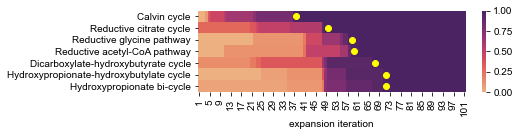

In [139]:
carbon_fixation = ['M00165','M00173','M00374','M00375','M00376','M00377','ReductiveGlycineModule']

module_set = pd.read_csv('assets/carbonFixationModuleRules.v2.csv')
# this is a biotin-dependent step, whcih can be performed via PEP carboxylase which always occurs earlier
module_set = module_set[~(module_set["step"] == "C00022 -> C00036")]
module_names = {}
module_names['M00165'] = 'Calvin cycle'
module_names['M00173'] = 'Reductive citrate cycle'
module_names['M00374'] = 'Dicarboxylate-hydroxybutyrate cycle'
module_names['M00375'] = 'Hydroxypropionate-hydroxybutylate cycle'
module_names['M00376'] = 'Hydroxypropionate bi-cycle'
module_names['M00377'] = 'Reductive acetyl-CoA pathway'
module_names['ReductiveGlycineModule'] = 'Reductive glycine pathway'

iterations = rn_df.iteration.unique().tolist()
module_coverage = {'module':[],'iteration':[],'coverage':[]}


# make a reaction df with ONLY extant reactions
rn_df_extant = rn_df[~rn_df.rn.apply(lambda x: ("H2Red" in x) | ("_RSH" in x))]


for i in iterations:
    rsub = rn_df_extant[rn_df_extant.iteration < (i+1)]
    #rsub =rn_df[rn_df.iteration < (i+1)]
    rsub = rsub.rn_kegg.unique()
    for module,mdf in module_set.groupby('module'):
        z = mdf.reactions.apply(lambda x: any([y in rsub for y in x.split(',')]))
        coverage = z.sum() / len(z)
        module_coverage['module'].append(module)
        module_coverage['iteration'].append(i)
        module_coverage['coverage'].append(coverage)

module_coverage = pd.DataFrame(module_coverage)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

M00357 = pd.DataFrame(module_coverage_piv[['M00357.v1','M00357.v2']].max(axis=1))
M00357.columns = ['coverage']
M00357['module'] = 'M00357'

module_coverage = pd.concat([module_coverage,M00357.reset_index()[['module','iteration','coverage']]],axis=0)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

pathway_completion_iteration = pd.Series({x:y[y.coverage == 1].iteration.min() for x,y in module_coverage.groupby('module')})

height = 6
mods = carbon_fixation
q = pd.DataFrame(pathway_completion_iteration.loc[mods].sort_values(),columns = ['iteration']).reset_index().reset_index()
q.columns = ['rank','module','iteration']
mods = pathway_completion_iteration.loc[mods].sort_values().index.tolist()
n = len(mods)
plt.figure(figsize=(height,(n/2)/14*height))

z = module_coverage_piv[mods].T
z.index = [module_names[x] for x in z.index.tolist()]

ax = sns.heatmap(z,cmap='flare',yticklabels=True)
plt.yticks(rotation=0)

#y = q['rank'].values + (n/2 / 10)
y = ax.get_yticks()

x = q['iteration'].values
plt.scatter(x,y,color='yellow')
plt.xlabel('expansion iteration')
#plt.savefig('carbonfixation.{date}.svg'.format(date=date))
#plt.savefig("figs/fig4c.svg")

/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


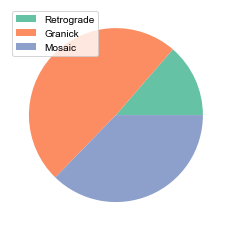

In [192]:
with open("assets/parsedLinearModules.pkl","rb") as filehandler:
    parsed_linear_modules = pickle.load(filehandler)
    
rn_df['rlabel'] = rn_df['rn_kegg'] + '_' + rn_df['direction']

iteration_step = []
for idx,row in parsed_linear_modules.iterrows():
    if rn_df.rlabel.isin(row.rxn_labels).sum() == len(row.rxn_labels):
        step_max = rn_df[rn_df.rlabel.isin(row.rxn_labels)].iteration.max()
    else:
        step_max = np.nan
    iteration_step.append(step_max)
    
parsed_linear_modules['iteration'] = iteration_step


module_correlations = {'module':[],'rule_id':[],'r':[],'pval':[],'ivar':[]}
for (module,rule),dff in parsed_linear_modules.groupby(['module','rule_id']):
    if ~dff.iteration.isna().any():
        if len(dff)>1:
            r,p = spearmanr(dff.step,dff.iteration)
            module_correlations['module'].append(module)
            module_correlations['rule_id'].append(rule)
            module_correlations['r'].append(r)
            module_correlations['pval'].append(p)
            module_correlations['ivar'].append(dff.iteration.var())
module_correlations = pd.DataFrame(module_correlations)
module_correlations = module_correlations[~module_correlations["r"].isna()]

retrograde = len(module_correlations[module_correlations.r < -0.99999999])
granick = len(module_correlations[module_correlations.r > 0.99999999])
mosiac = len(module_correlations) - retrograde - granick

plt.figure(figsize=(4,4))
cmap2 = sns.color_palette("Set2")
plt.pie([retrograde,granick,mosiac],colors=cmap2)
plt.legend(['Retrograde','Granick','Mosaic'])
#plt.savefig("figs/fig4a.svg")

In [200]:
mosiac / sum([retrograde,granick,mosiac])

0.37272727272727274

In [201]:
mosiac

41

In [193]:
#module_names = pd.read_csv("assets/kegg_modules.csv")

In [195]:
module_correlations[~module_correlations["r"].isna()]

,module,rule_id,r,pval,ivar
1,M00006,1,-0.866025,0.333333,0.333333
2,M00006,2,0.866025,0.333333,0.333333
3,M00006,3,0.000000,1.000000,0.333333
4,M00008,0,-0.948683,0.051317,69.666667
5,M00013,0,-0.900000,0.037386,137.300000
...,...,...,...,...,...
109,M00910,1,1.000000,0.000000,1.000000
110,M00918,0,1.000000,0.000000,1.666667
111,M00919,0,0.200000,0.800000,16.666667
112,M00923,0,0.974679,0.004818,1.300000


In [178]:
module_correlations = module_correlations.set_index("module").join(module_names.set_index("md"))

In [179]:
m = module_correlations[["name","rule_id","r"]]

In [189]:
m.sort_values("r").iloc[0:20]

,name,rule_id,r
M00131,"Inositol phosphate metabolism, Ins(1,3,4,5)P4 ...",0,-1.000000
M00568,"Catechol ortho-cleavage, catechol => 3-oxoadipate",0,-1.000000
M00538,"Toluene degradation, toluene => benzoate",0,-1.000000
M00531,"Assimilatory nitrate reduction, nitrate => amm...",0,-1.000000
M00555,"Betaine biosynthesis, choline => betaine",13,-1.000000
M00579,Phosphate acetyltransferase-acetate kinase pat...,0,-1.000000
M00174,"Methane oxidation, methanotroph, methane => fo...",1,-1.000000
M00533,"Homoprotocatechuate degradation, homoprotocate...",0,-1.000000
M00531,"Assimilatory nitrate reduction, nitrate => amm...",2,-1.000000
M00531,"Assimilatory nitrate reduction, nitrate => amm...",1,-1.000000
